# [Seq2Seq and Attention](https://tutorials.pytorch.kr/intermediate/seq2seq_translation_tutorial.html)

### Seq2Seq 한계

Seq2Seq 모델은 번역(translation), 챗봇 등의 task에서 높은 성능을 보였다. 하지만 Seq2Seq 모델은 커다란 한계가 있었다.

- 입력 시퀸스의 모든 정보를 하나의 고정된 크기의 벡터(컨텍스트 벡터)에 다 압축 요약하려 하다 보니 정보의 손실이 생길 수밖에 없다. 특히 시퀸스의 길이가 길다면 정보의 손실이 더 커진다.
- RNN 구조로 만들어진 모델이다 보니, 필연적으로 gradient vaninshing/exploding 현상이 발생한다.

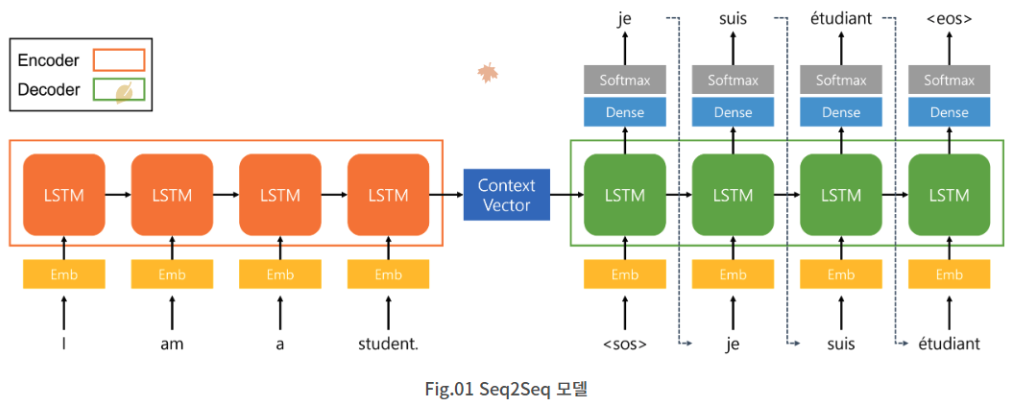

## [Attention Mechanism](https://wikidocs.net/22893)

어텐션 메커니즘은 Seq2Seq 모델의 문제점을 개선하기 위해 제안되었다.   

구체적으로, 어텐션 메커니즘은 다음을 가정한다.  
> 디코더가 단어 X를 출력하기 직전의 디코더 은닉 상태는 인코더가 입력 시퀀스에서 X와 연관이 깊은 단어를 읽은 직후의 인코더 은닉 상태와 유사할 것이다.   

예를 들어 영어 문장 "I am a student."을 한국어 문장 "나는 학생이다."로 번역하는 상황을 생각해 보자. 출력 시퀀스의 단어 "학생"은 입력 시퀀스의 단어 "I", "am", "a", "student", "." 중에서 "student"와 연관이 깊다.    
이때 `어텐션 메커니즘`은 디코더가 "학생"을 출력하기 직전의 은닉 상태는 인코더가 "student"를 입력받은 직후의 은닉 상태와 유사할 것이라고 가정한다.    
따라서 인코더가 "student"를 입력받은 직후의 은닉 상태에 조금 더 "집중"하면, 훨씬 더 품질 높은 번역을 만들 수 있을 것이다.

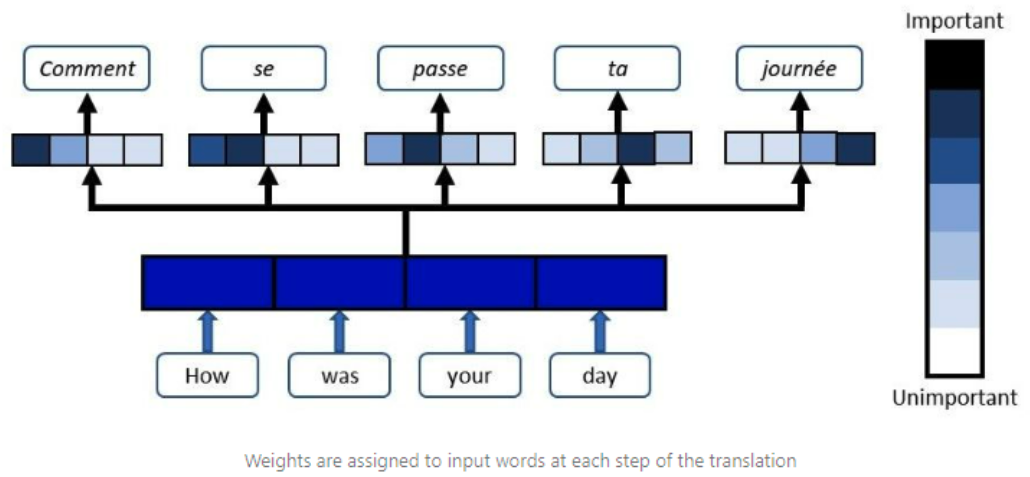

### Attention 동작 방법
- Q = Query : t 시점의 디코더 셀에서의 은닉 상태
- K = Keys : 모든 시점의 인코더 셀의 은닉 상태들
- V = Values : 모든 시점의 인코더 셀의 은닉 상태들

1. 어텐션 스코어(유사도)를 구한다. 
- 알고 싶은 Query(특정 output)의 hidden state가 각 Keys(input)들의 hidden state와 dot product를 계산하여 유사도를 구한다.

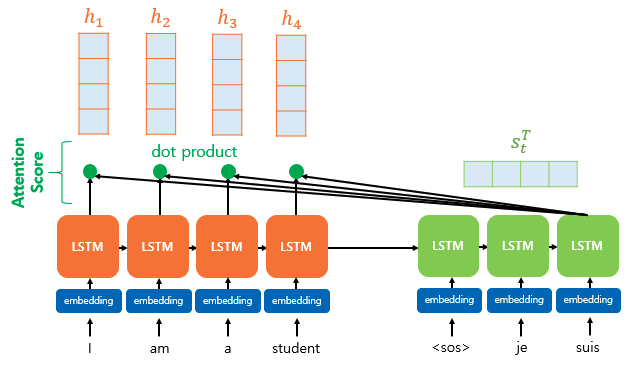

2. 소프트맥스(softmax) 함수를 통해 어텐션 분포(Attention Distribution)를 구한다. 
- 소프트맥스를 이용하여 어텐션 스코어의 활률 분포를 구한다. (즉, 유사도 가중치)

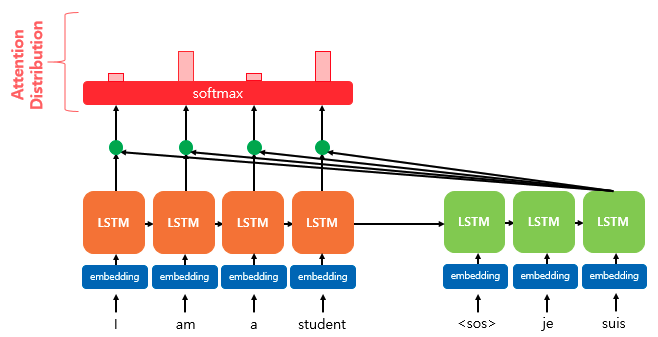

3. 각 인코더의 어텐션 가중치와 은닉 상태를 가중합하여 어텐션 값(Attention Value)을 구한다. 
- 각 Keys(input)들의 hidden state와 유사도의 가중치들을 곱해서 어텐션 값을 구한다.
- 유사도의 가중치에 따라서 어텐션 값이 달라지게 되므로 해당 값을 통해서 어떤 input 데이터를 중요하게 생각해야 하는지를 알게되는 것이다.

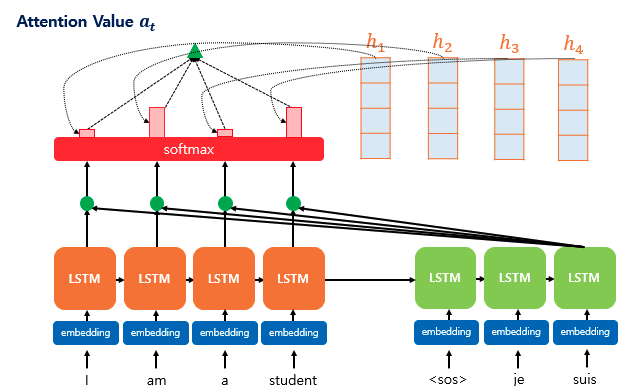

4. 어텐션 값과 디코더의 t시점의 은닉 상태를 연결한다. (concatenate)

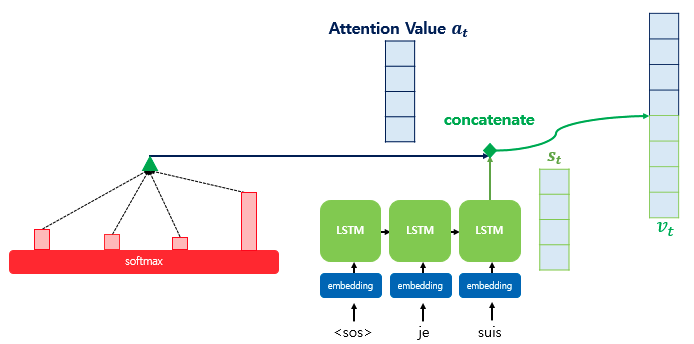

5. Dense layer와 softmax를 적용한다.

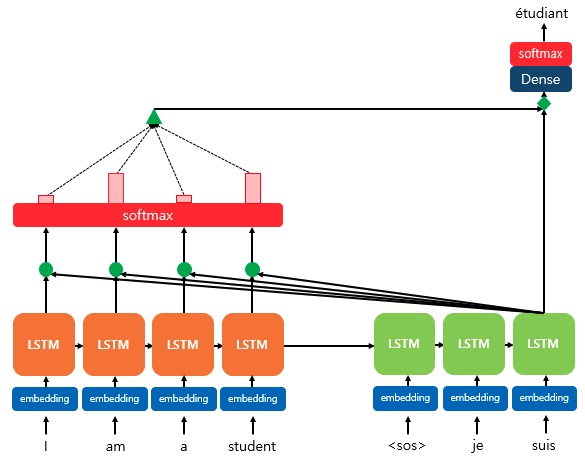

### 스코어 함수

query와 key 사이의 유사도를 구하는 함수를 스코어 함수라고 한다.   
아래 이미지는 유명한 스코어 함수들을 정리한 표이다.

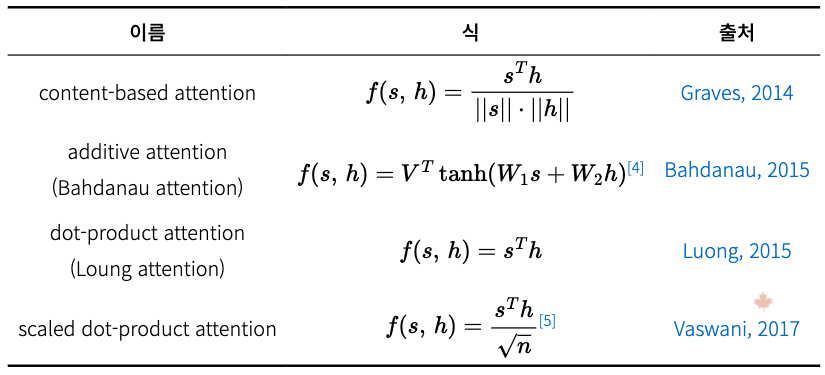

## Seq2Seq with Attention 동작 방법

1. 어느 시점의 인코더 은닉 상태에 조금 더 "집중"해야 하는지 찾기 위해, 현재 디코더의 은닉 상태와 매 시점 인코더의 은닉 상태들 간 "유사도"를 계산한다.  
2. 이 유사도를 확률의 형태로 바꾸고, 그 값에 따라 인코더 은닉 상태들의 가중합(weighted sum)을 구해 "보정된 컨텍스트 벡터"를 구한다.  
3. "보정된 컨텍스트 벡터"을 이용해 다음 단어를 예측한다.  

# [Simple Seq2Seq with Attention](https://colab.research.google.com/github/graykode/nlp-tutorial/blob/master/4-2.Seq2Seq(Attention)/Seq2Seq(Attention).ipynb)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
n_step = 5 # number of cells(= number of Step)
n_hidden = 128 # number of hidden units in one cell

## 데이터 

### 데이터 생성 

In [3]:
sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']
len(sentences)

3

### 데이터 토큰화 

In [4]:
word_list = " ".join(sentences).split()
word_list = list(set(word_list))
len(word_list) # 총 단어의 수 

11

### 데이터 사전 

In [5]:
word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i: w for i, w in enumerate(word_list)}
n_class = len(word_dict)  # vocab list
n_class # 총 단어의 수

11

## Dataset

In [6]:
def make_batch():
    input_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[0].split()]]]
    output_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[1].split()]]]
    target_batch = [[word_dict[n] for n in sentences[2].split()]]

    # make tensor
    return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)

In [7]:
input, output, target = make_batch()
input.shape, output.shape, target.shape # input: [batch_size, word_size, total_word_size]

<ipython-input-6-df2f7966fba9>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)


(torch.Size([1, 5, 11]), torch.Size([1, 5, 11]), torch.Size([1, 5]))

## 모델 

### 디버깅 

In [8]:
enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)

attn = nn.Linear(n_hidden, n_hidden)
out = nn.Linear(n_hidden * 2, n_class)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [9]:
hidden = torch.zeros(1, 1, n_hidden)
hidden.shape # hidden: [batch_size, one_word(word_size), hidden_size]

torch.Size([1, 1, 128])

In [10]:
# input, output, target
enc_inputs = input.transpose(0, 1)
dec_inputs = output.transpose(0, 1)

enc_inputs.shape, dec_inputs.shape # enc_inputs: [word_size, batch_size, total_word_size]

(torch.Size([5, 1, 11]), torch.Size([5, 1, 11]))

In [11]:
enc_outputs, enc_hidden = enc_cell(enc_inputs, hidden)

enc_outputs.shape, enc_hidden.shape # enc_outputs: [word_size, batch_size, hidden_size], enc_hidden: [one_word(word_size), batch_size, hidden_size]

(torch.Size([5, 1, 128]), torch.Size([1, 1, 128]))

In [12]:
trained_attn = []
hidden = enc_hidden # context vector
n_step = len(dec_inputs)

hidden.shape, n_step # n_step: word_size

(torch.Size([1, 1, 128]), 5)

In [13]:
response = torch.empty([n_step, 1, n_class]) 
response.shape # response: [word_size, batch_size, total_word_size] -> 번역 결과를 저장할 변수 

torch.Size([5, 1, 11])

In [14]:
dec_inputs[0].shape # dec_inputs[0]: [batch_size, total_word_size]

torch.Size([1, 11])

In [15]:
dec_inputs[0].unsqueeze(0).shape # dec_inputs[0]: [one_word(word_size), batch_size, total_word_size]

torch.Size([1, 1, 11])

In [16]:
hidden.shape # hidden: [one_word(word_size), batch_size, hidden_size]

torch.Size([1, 1, 128])

In [17]:
dec_output, hidden = dec_cell(dec_inputs[0].unsqueeze(0), hidden)

dec_output.shape, hidden.shape # dec_output: [one_word(word_size), batch_size, hidden_size]

(torch.Size([1, 1, 128]), torch.Size([1, 1, 128]))

In [18]:
def get_att_score(dec_output, enc_output):  # enc_outputs [batch_size, num_directions(=1) * n_hidden]
  score = attn(enc_output)  # score : [batch_size, n_hidden]
  return torch.dot(dec_output.view(-1), score.view(-1))  # inner product make scalar value

In [19]:
def get_att_weight(dec_output, enc_outputs):  # get attention weight one 'dec_output' with 'enc_outputs'
  n_step = len(enc_outputs) # n_step: word_size(단어의 수)
  attn_scores = torch.zeros(n_step)  # attn_scores : 단어별 attn score를 저장할 변수 

  for i in range(n_step):
      attn_scores[i] = get_att_score(dec_output, enc_outputs[i]) # 단어별 atten score 저장 

  # Normalize scores to weights in range 0 to 1
  return F.softmax(attn_scores).view(1, 1, -1) # atten value 리턴 

In [20]:
# dec_output: [one_word(word_size), batch_size, hidden_size], enc_outputs: [word_size, batch_size, hidden_size]
dec_output.shape, enc_outputs.shape 

(torch.Size([1, 1, 128]), torch.Size([5, 1, 128]))

In [21]:
attn_weights = get_att_weight(dec_output, enc_outputs)
attn_weights.shape # attn_weights: [batch_size, atten_weight_size, word_size]

<ipython-input-19-2e788d0a50de>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(attn_scores).view(1, 1, -1) # atten value 리턴


torch.Size([1, 1, 5])

In [22]:
attn_weights.squeeze() # attn_weights.squeeze(): 단어별 확률값 

tensor([0.2071, 0.1981, 0.2074, 0.2003, 0.1871], grad_fn=<SqueezeBackward0>)

In [23]:
attn_weights.squeeze().sum() # 전체 확률값의 합은 1

tensor(1., grad_fn=<SumBackward0>)

In [24]:
# enc_outputs.transpose(0, 1): [batch_size, word_size, hidden_size]
attn_values = attn_weights.bmm(enc_outputs.transpose(0, 1))
attn_values.shape # attn_values: [batch_size, atten_weight_size, hidden_size]

torch.Size([1, 1, 128])

In [25]:
dec_output = dec_output.squeeze(0)
dec_output.shape # [batch_size, hidden_size]

torch.Size([1, 128])

In [26]:
attn_values = attn_values.squeeze(1)
attn_values.shape # [batch_size, hidden_size]

torch.Size([1, 128])

In [27]:
output_cat = torch.cat((dec_output, attn_values), 1)
output_cat.shape # [batch_size, (hidden_size + hidden_size)]

torch.Size([1, 256])

In [28]:
out_linear = nn.Linear(n_hidden * 2, n_class)

In [29]:
out = out_linear(output_cat)
out.shape # 전체 단어중 가장 알맞은 단어 리턴 

torch.Size([1, 11])

In [30]:
response.shape 

torch.Size([5, 1, 11])

In [31]:
response[0] = out # 첫번째 알맞은 단어 리턴 

### 모델 생성 

In [32]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
        self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)

        # Linear for attention
        self.attn = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden * 2, n_class)

    def forward(self, enc_inputs, hidden, dec_inputs):
        enc_inputs = enc_inputs.transpose(0, 1)  # enc_inputs: [n_step(=n_step, time step), batch_size, n_class]
        dec_inputs = dec_inputs.transpose(0, 1)  # dec_inputs: [n_step(=n_step, time step), batch_size, n_class]

        # enc_outputs : [n_step, batch_size, num_directions(=1) * n_hidden], matrix F
        # enc_hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        enc_outputs, enc_hidden = self.enc_cell(enc_inputs, hidden)

        trained_attn = []
        hidden = enc_hidden # context vector
        n_step = len(dec_inputs)
        response = torch.empty([n_step, 1, n_class]) # 변역 결과를 저장할 응답 변수 

        for i in range(n_step):  # each time step
            # dec_output : [n_step(=1), batch_size(=1), num_directions(=1) * n_hidden]
            # hidden : [num_layers(=1) * num_directions(=1), batch_size(=1), n_hidden]
            dec_output, hidden = self.dec_cell(dec_inputs[i].unsqueeze(0), hidden)
            attn_weights = self.get_att_weight(dec_output, enc_outputs)  # attn_weights : [1, 1, n_step]
            trained_attn.append(attn_weights.squeeze().data.numpy()) # attn_weights 저장 

            # matrix-matrix product of matrices [1,1,n_step] x [1,n_step,n_hidden] = [1,1,n_hidden]
            attn_values = attn_weights.bmm(enc_outputs.transpose(0, 1)) # attn_values
            dec_output = dec_output.squeeze(0)  # dec_output : [batch_size(=1), num_directions(=1) * n_hidden]
            attn_values = attn_values.squeeze(1)  # [1, num_directions(=1) * n_hidden]
            response[i] = self.out(torch.cat((dec_output, attn_values), 1))

        # make response shape [n_step, n_class]
        return response.transpose(0, 1).squeeze(0), trained_attn

    def get_att_weight(self, dec_output, enc_outputs):  # get attention weight one 'dec_output' with 'enc_outputs'
        n_step = len(enc_outputs)
        attn_scores = torch.zeros(n_step)  # attn_scores : [n_step]

        for i in range(n_step):
            attn_scores[i] = self.get_att_score(dec_output, enc_outputs[i])

        # Normalize scores to weights in range 0 to 1
        return F.softmax(attn_scores).view(1, 1, -1)

    def get_att_score(self, dec_output, enc_output):  # enc_outputs [batch_size, num_directions(=1) * n_hidden]
        score = self.attn(enc_output)  # score : [batch_size, n_hidden]
        return torch.dot(dec_output.view(-1), score.view(-1))  # inner product make scalar value

## 학습 

In [33]:
# hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
hidden = torch.zeros(1, 1, n_hidden)

model = Attention()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

input_batch, output_batch, target_batch = make_batch()

# Train
for epoch in range(2000):
    
    output, _ = model(input_batch, hidden, output_batch)

    loss = criterion(output, target_batch.squeeze(0))
    if (epoch + 1) % 400 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

<ipython-input-32-d1bcf026ed7e>:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(attn_scores).view(1, 1, -1)


Epoch: 0400 cost = 0.000497
Epoch: 0800 cost = 0.000161
Epoch: 1200 cost = 0.000079
Epoch: 1600 cost = 0.000046
Epoch: 2000 cost = 0.000030


## 평가 

In [34]:
# Test
test_batch = [np.eye(n_class)[[word_dict[n] for n in 'SPPPP']]]
test_batch = torch.FloatTensor(test_batch)
predict, trained_attn = model(input_batch, hidden, test_batch)
predict = predict.data.max(1, keepdim=True)[1]
print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

ich mochte ein bier P -> ['i', 'want', 'a', 'beer', 'E']


<ipython-input-32-d1bcf026ed7e>:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(attn_scores).view(1, 1, -1)


<ipython-input-35-4de4c42c3437>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
<ipython-input-35-4de4c42c3437>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})


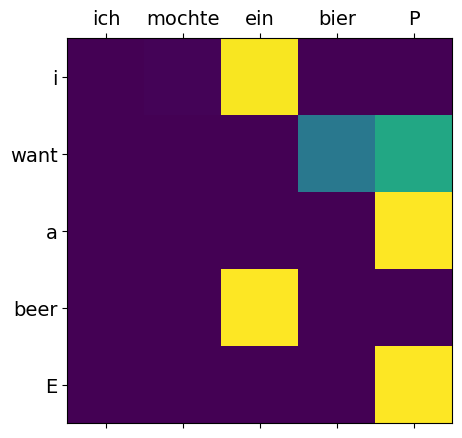

In [35]:
# Show Attention
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.matshow(trained_attn, cmap='viridis')
ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})
plt.show()

# [Simple Bi-LSTM with Attention](https://github.com/graykode/nlp-tutorial/blob/master/4-3.Bi-LSTM(Attention)/Bi-LSTM(Attention).py)

In [36]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

## 데이터

In [37]:
embedding_dim = 2 # embedding size
n_hidden = 5  # number of hidden units in one cell
num_classes = 2  # 0 or 1

# 3 words sentences (=sequence_length is 3)
sentences = ["i love you", "he loves me", "she likes baseball", "i hate you", "sorry for that", "this is awful"]
labels = [1, 1, 1, 0, 0, 0]  # 1 is good, 0 is not good.

word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
vocab_size = len(word_dict)

## 모델 

In [38]:
class BiLSTM_Attention(nn.Module):
    def __init__(self):
        super(BiLSTM_Attention, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, n_hidden, bidirectional=True)
        self.out = nn.Linear(n_hidden * 2, num_classes)

    # lstm_output : [batch_size, n_step, n_hidden * num_directions(=2)], F matrix
    def attention_net(self, lstm_output, final_state):
        hidden = final_state.view(-1, n_hidden * 2, 1)   # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, n_step]
        soft_attn_weights = F.softmax(attn_weights, 1)
        # [batch_size, n_hidden * num_directions(=2), n_step] * [batch_size, n_step, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context, soft_attn_weights.data.numpy() # context : [batch_size, n_hidden * num_directions(=2)]

    def forward(self, X):
        input = self.embedding(X) # input : [batch_size, len_seq, embedding_dim]
        input = input.permute(1, 0, 2) # input : [len_seq, batch_size, embedding_dim]

        hidden_state = torch.zeros(1*2, len(X), n_hidden) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        cell_state = torch.zeros(1*2, len(X), n_hidden) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]

        # final_hidden_state, final_cell_state : [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        output, (final_hidden_state, final_cell_state) = self.lstm(input, (hidden_state, cell_state))
        output = output.permute(1, 0, 2) # output : [batch_size, len_seq, n_hidden]
        attn_output, attention = self.attention_net(output, final_hidden_state)
        return self.out(attn_output), attention # model : [batch_size, num_classes], attention : [batch_size, n_step]

## 학습 

In [39]:
model = BiLSTM_Attention()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

inputs = torch.LongTensor([np.asarray([word_dict[n] for n in sen.split()]) for sen in sentences])
targets = torch.LongTensor([out for out in labels])  # To using Torch Softmax Loss function

# Training
for epoch in range(5000):
    output, attention = model(inputs)
    loss = criterion(output, targets)
    if (epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 1000 cost = 0.003796
Epoch: 2000 cost = 0.000954
Epoch: 3000 cost = 0.000380
Epoch: 4000 cost = 0.000178
Epoch: 5000 cost = 0.000089


## 평가 

In [40]:
# Test
test_text = 'sorry hate you'
tests = [np.asarray([word_dict[n] for n in test_text.split()])]
test_batch = torch.LongTensor(tests)

sorry hate you is Bad Mean...


<ipython-input-41-b3555f71b10a>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['first_word', 'second_word', 'third_word'], fontdict={'fontsize': 14}, rotation=90)
<ipython-input-41-b3555f71b10a>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['batch_1', 'batch_2', 'batch_3', 'batch_4', 'batch_5', 'batch_6'], fontdict={'fontsize': 14})


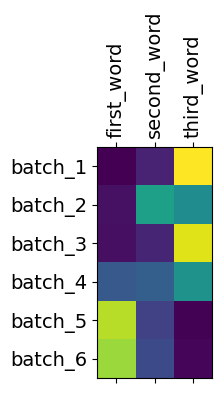

In [41]:
# Predict
predict, _ = model(test_batch)
predict = predict.data.max(1, keepdim=True)[1]
if predict[0][0] == 0:
    print(test_text,"is Bad Mean...")
else:
    print(test_text,"is Good Mean!!")

fig = plt.figure(figsize=(6, 3)) # [batch_size, n_step]
ax = fig.add_subplot(1, 1, 1)
ax.matshow(attention, cmap='viridis')
ax.set_xticklabels(['']+['first_word', 'second_word', 'third_word'], fontdict={'fontsize': 14}, rotation=90)
ax.set_yticklabels(['']+['batch_1', 'batch_2', 'batch_3', 'batch_4', 'batch_5', 'batch_6'], fontdict={'fontsize': 14})
plt.show()

# Advanced Seq2Seq with Attention

## 1.데이터 파일 로딩

In [42]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

문자 단위 RNN 튜토리얼에서 사용된 문자 인코딩과 유사하게, 언어의 각 단어들을 One-Hot Vector로 표현합니다. 언어마다 수십 개의 문자가 있어서 인코딩 벡터는 매우 큽니다.   
  
그러나 우리는 약간의 트릭을 써서 언어 당 수천 단어만 사용하도록 데이터를 다듬을 것입니다.  

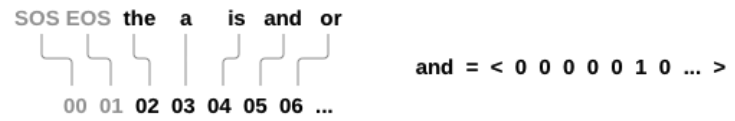

나중에 네트워크의 입력 및 목표로 사용하려면 단어 당 고유 번호가 필요합니다. 이 모든 것을 추적하기 위해 우리는 `단어-색인(word2index)`과 `색인-단어(index2word)` 사전, 그리고 나중에 희구 단어를 대체하는데 사용할 각 `단어의 빈도(word2count)`를 가진 Lang 클라스를 만듭니다.  
  
- SOS token: Start Of String Token
- EOS token: End Of String Token

In [43]:
# 구글 드라이브 연결(데이터 로드를 위해서)
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [50]:
DATA_PATH = "/content/data/MyDrive/google_lecture/06. deep learning/3. NLP Pytorch/data/"

In [51]:
SOS_token = 0 # Start Of String Token
EOS_token = 1 # End Of String Token


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {} # 단어 - 색인
        self.word2count = {} # 단어 빈도 수
        self.index2word = {0: "SOS", 1: "EOS"} # 색인 - 단어
        self.n_words = 2  # SOS 와 EOS 포함

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

파일은 모두 유니코드로 되어있어 간단하게하기 위해 유니코드 문자를 ASCII로 변환하고, 모든 문자를 소문자로 만들고, 대부분의 구두점을 지워줍니다.

In [52]:
# 유니 코드 문자열을 일반 ASCII로 변환하십시오.
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

In [53]:
# 소문자, 다듬기, 그리고 문자가 아닌 문자 제거
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [54]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # 파일을 읽고 줄로 분리
    lines = open(DATA_PATH+'%s-%s.txt' % ('eng', 'fra'), encoding='utf-8').\
        read().strip().split('\n')

    # 모든 줄을 쌍으로 분리하고 정규화
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # 쌍을 뒤집고, Lang 인스턴스 생성
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [55]:
input_lang, output_lang, pairs = readLangs('eng', 'fra', True)

Reading lines...


In [56]:
MAX_LENGTH = 10 #최대 길이

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

In [57]:
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [58]:
input_lang, output_lang, pairs = readLangs('eng', 'fra', True)

print(f'{len(pairs)}')
pairs[:10]

Reading lines...
135842


[['va !', 'go .'],
 ['cours !', 'run !'],
 ['courez !', 'run !'],
 ['ca alors !', 'wow !'],
 ['au feu !', 'fire !'],
 ['a l aide !', 'help !'],
 ['saute .', 'jump .'],
 ['ca suffit !', 'stop !'],
 ['stop !', 'stop !'],
 ['arrete toi !', 'stop !']]

In [59]:
pairs[0]

['va !', 'go .']

In [60]:
filterPair(pairs[0])

False

In [61]:
filter_pairs = filterPairs(pairs[:10])
filter_pairs

[]

In [62]:
filter_pairs = filterPairs(pairs)

print(f'{len(filter_pairs)}')
filter_pairs[:3]

10599


[['j ai ans .', 'i m .'],
 ['je vais bien .', 'i m ok .'],
 ['ca va .', 'i m ok .']]

In [63]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [64]:
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je suis le cousin de tom .', 'i m tom s cousin .']


## 2.Seq2Seq Model

Sequence to Sequence network, 또는 Seq2Seq 네트워크, 또는 encoder Decoder network는 인코더 및 디코더라고 하는 두 개의 RNN으로 구성된 모델입니다.   
  
인코더는 입력 시퀀스를 읽고 단일 벡터를 출력하고, 디코더는 해당 벡터를 읽어 출력 시퀀스를 생성합니다.

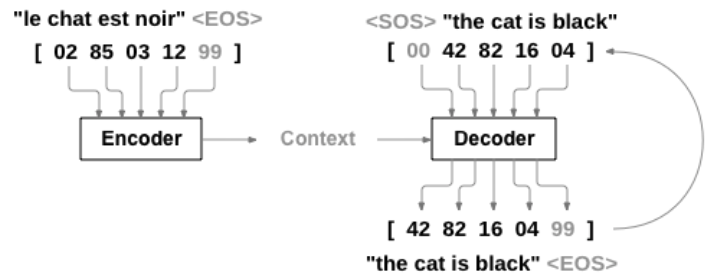

### Encoder

Seq2Seq 네트워크의 인코더는 입력 문장의 모든 단어에 대해 어떤 값을 출력하는 RNN입니다. 모든 입력 단어에 대해 인코더는 벡터와 은닉 상태를 출력하고 다음 입력 단어를 위해 그 은닉 상태를 사용합니다.

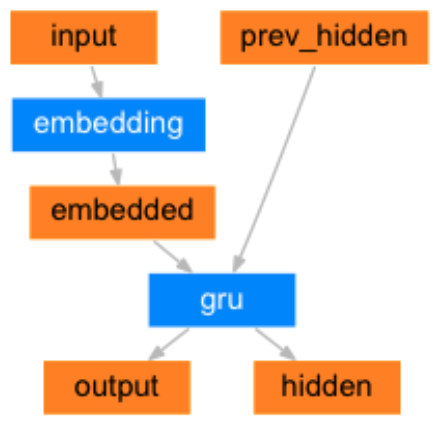

In [65]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Decoder
> 디코더는 인코더 출력 벡터를 받아서 번역을 생성하기 위한 단어 시퀀스를 출력합니다.

#### 간단한 디코더
가장 간단한 Seq2Seq 디코더는 인코더의 마지막 출력만을 이용합니다. 이 마지막 출력은 전체 시퀀스에서 문맥을 인코드하기 때문에 문맥 벡터(context vector)로 불립니다. 이 문맥 벡터는 디코더의 초기 인닉 상태로 사용됩니다.

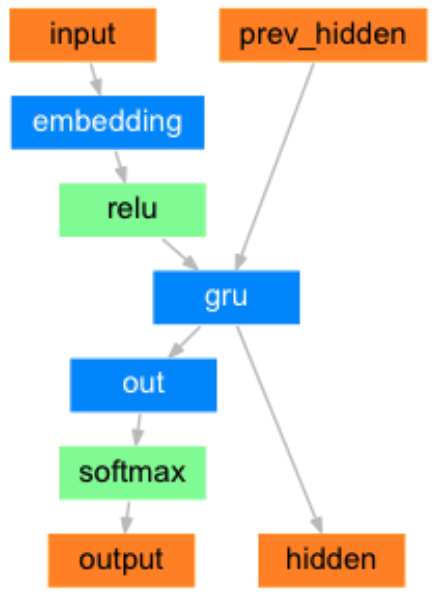

In [66]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### Attention 디코더

문맥 벡터(context vector)만 인코더와 디코더 사이로 전달 된다면, 단일 벡터가 전체 문장을 인코딩 해야하는 부담을 가지게 됩니다.   
  
Attention은 디코더 네트워크가 자기 출력의 모든 단계에서 인코더 출력의 다른 부분에 집중 할 수 있게 합니다.

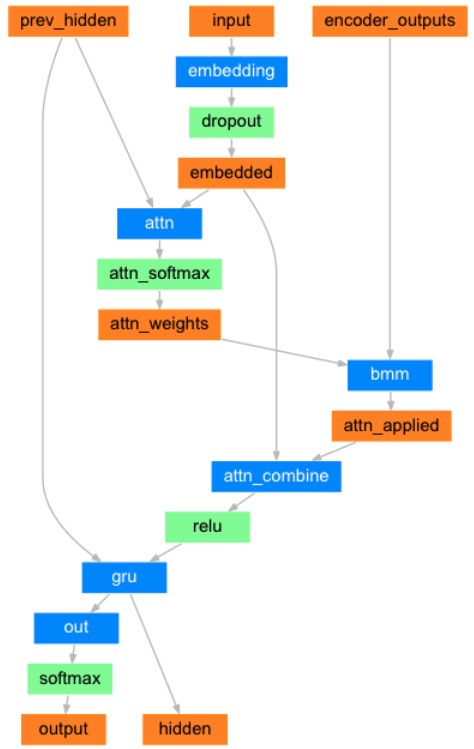

In [67]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## 3.학습

### 학습 데이터 준비
> 학습을 위해서, 각 쌍마다 입력 Tensor(입력 문장의 단어 주소)와 목표 Tensor(목표 문장의 단어 주소)가 필요합니다. 이 벡터들을 생성하는 동안 두 시퀀스에 EOS 토큰을 추가 합니다.

In [68]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence) # sentence to tokens
    indexes.append(EOS_token) # tokens add EOS_token
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1) # view(-1, 1): (n, 1) 차원으로 변경


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### 모델 학습

학습을 위해서 인코더에 입력 문장을 넣고 모든 출력과 최신 은닉 상태를 추적합니다. 그런 다음 디코더에 첫 번재 입력으로 `<SOS>` 토큰과 인코더의 마지막 은닉 상태가 첫 번째 은닉 상태로 제공됩니다.   

In [69]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0) # 글자 수 
    target_length = target_tensor.size(0) # 글자 수 

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing 포함: 목표를 다음 입력으로 전달
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Teacher forcing 미포함: 자신의 예측을 다음 입력으로 사용
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # 입력으로 사용할 부분을 히스토리에서 분리

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

이것은 현재 시간과 진행률%을 고려해 경과된 시간과 남은 예상 시간을 출력하는 헬퍼 함수입니다.

In [70]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

> 결과 도식화

In [71]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

> 전체 학습 과정
- 타이머 시작
- optimizers와 criterion 초기화
- 학습 쌍의 세트 생성
- 도식화를 위한 빈 손실 배열 시작

In [72]:
training_pairs = [
        tensorsFromPair(random.choice(pairs)) for i in range(10)]

In [73]:
random.choice(pairs)

['ca va merci .', 'i m fine thank you .']

In [74]:
len(training_pairs)

10

In [75]:
training_pairs[0][0].shape

torch.Size([6, 1])

In [76]:
training_pairs[0]

(tensor([[ 118],
         [ 118],
         [1760],
         [   8],
         [   5],
         [   1]], device='cuda:0'),
 tensor([[129],
         [ 78],
         [964],
         [  4],
         [  1]], device='cuda:0'))

In [77]:
from tqdm.auto import tqdm

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # print_every 마다 초기화
    plot_loss_total = 0  # plot_every 마다 초기화

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [
        tensorsFromPair(random.choice(pairs)) for i in range(n_iters)] # 학습할 언어 셋(프랑스, 영어) 리스트
    criterion = nn.NLLLoss()

    for iter in tqdm(range(1, n_iters + 1)):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                    decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

## 4.평가

평가는 대부분 학습과 동일하지만 목표가 없으므로 각 단계마다 디코더의 예측을 되돌려 전달합니다.     
단어를 예측할 때마다 그 단어를 출력 문자열에 추가합니다. 만약 `EOS` 토큰을 예측하면 거기에서 멈춥니다.

In [78]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                    encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

학습 세트에 있는 임의의 문장을 평가하고 입력, 목표 및 출력을 하여 주관적인 품질 판단을 내릴 수 있습니다.

In [79]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## 5.학습과 평가

In [80]:
import time

hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

  0%|          | 0/75000 [00:00<?, ?it/s]

1m 38s (- 22m 57s) (5000 6%) 2.8790
3m 9s (- 20m 31s) (10000 13%) 2.2753
4m 46s (- 19m 4s) (15000 20%) 1.9680
6m 18s (- 17m 21s) (20000 26%) 1.6945
7m 50s (- 15m 41s) (25000 33%) 1.5278
9m 22s (- 14m 3s) (30000 40%) 1.3462
10m 53s (- 12m 27s) (35000 46%) 1.1807
12m 25s (- 10m 52s) (40000 53%) 1.0822
13m 57s (- 9m 18s) (45000 60%) 0.9778
15m 28s (- 7m 44s) (50000 66%) 0.8786
17m 1s (- 6m 11s) (55000 73%) 0.7911
18m 33s (- 4m 38s) (60000 80%) 0.7045
20m 5s (- 3m 5s) (65000 86%) 0.6544
21m 36s (- 1m 32s) (70000 93%) 0.5958
23m 9s (- 0m 0s) (75000 100%) 0.5601


In [81]:
evaluateRandomly(encoder1, attn_decoder1)

> je suis tres en faveur de cela .
= i m very much in favor of this .
< i m very much in favor of this . <EOS>

> tu n aides pas .
= you re not helping .
< you re not helping . <EOS>

> je parle bien japonais .
= i m good at japanese .
< i m good at japanese . <EOS>

> prendre des photos m interesse .
= i am interested in taking pictures .
< he s fond of taking pictures . <EOS>

> il est ecrivain .
= he is a writer .
< he is a writer . <EOS>

> elle est habituee a se lever tot .
= she s used to getting up early .
< she s used to getting up early . <EOS>

> vous vous etes trompe d avion .
= you are on the wrong plane .
< you are looking for the of . <EOS>

> elles sont tres grandes .
= they are very big .
< they are very big . <EOS>

> je ne vais pas me disputer avec vous !
= i m not going to argue with you .
< i m not going to argue with you . <EOS>

> il simule .
= he s faking .
< he s gone . <EOS>



### Atention 시각화

Attention 메커니즘의 유용한 속성은 하나는 해석 가능성이 높은 출력입니다. 입력 시퀀스의 특정 인코더 출력에 가중치를 부여하는 데 사용되므로 각 시간 단계에서 네트워크가 가장 집중되는 위치를 파악할 수 있습니다. 

In [82]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

더 나은 보기를 위해 축과 라벨을 더하는 추가 작업을 수행합니다.

In [83]:
def showAttention(input_sentence, output_words, attentions):
    # colorbar로 그림 설정
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # 축 설정
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                        ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 매 틱마다 라벨 보여주기
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [84]:
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

In [85]:
evaluateAndShowAttention("elle a cinq ans de moins que moi .")

input = elle a cinq ans de moins que moi .
output = she s five years younger than me . <EOS>


<ipython-input-83-6c6995293660>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-83-6c6995293660>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


In [86]:
evaluateAndShowAttention("elle est trop petit .")

input = elle est trop petit .
output = she s too too . <EOS>


<ipython-input-83-6c6995293660>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-83-6c6995293660>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


In [87]:
evaluateAndShowAttention("je ne crains pas de mourir .")

input = je ne crains pas de mourir .
output = i m not afraid of die . <EOS>


<ipython-input-83-6c6995293660>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-83-6c6995293660>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


In [88]:
evaluateAndShowAttention("c est un jeune directeur plein de talent .")

input = c est un jeune directeur plein de talent .
output = he s a talented young . . <EOS>


<ipython-input-83-6c6995293660>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-83-6c6995293660>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)
